In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import DensityMatrix, concurrence
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

# Bell circuit
def bell_circuit():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    return qc

# Depolarizing noise model
def depol_noise(p):
    noise = NoiseModel()
    error1 = depolarizing_error(p, 1)
    error2 = depolarizing_error(p, 2)
    noise.add_all_qubit_quantum_error(error1, ["h"])
    noise.add_all_qubit_quantum_error(error2, ["cx"])
    return noise

noise_levels = np.linspace(0, 0.3, 12)
concurrence_values = []

ideal_dm = DensityMatrix.from_instruction(bell_circuit())

for p in noise_levels:
    qc = bell_circuit()
    qc.save_density_matrix()   

    sim = AerSimulator(
        noise_model=depol_noise(p),
        method="density_matrix"
    )

    tqc = transpile(qc, sim)
    result = sim.run(tqc).result()

    noisy_dm = DensityMatrix(result.data(0)["density_matrix"])
    concurrence_values.append(concurrence(noisy_dm))


Plot and save the figure

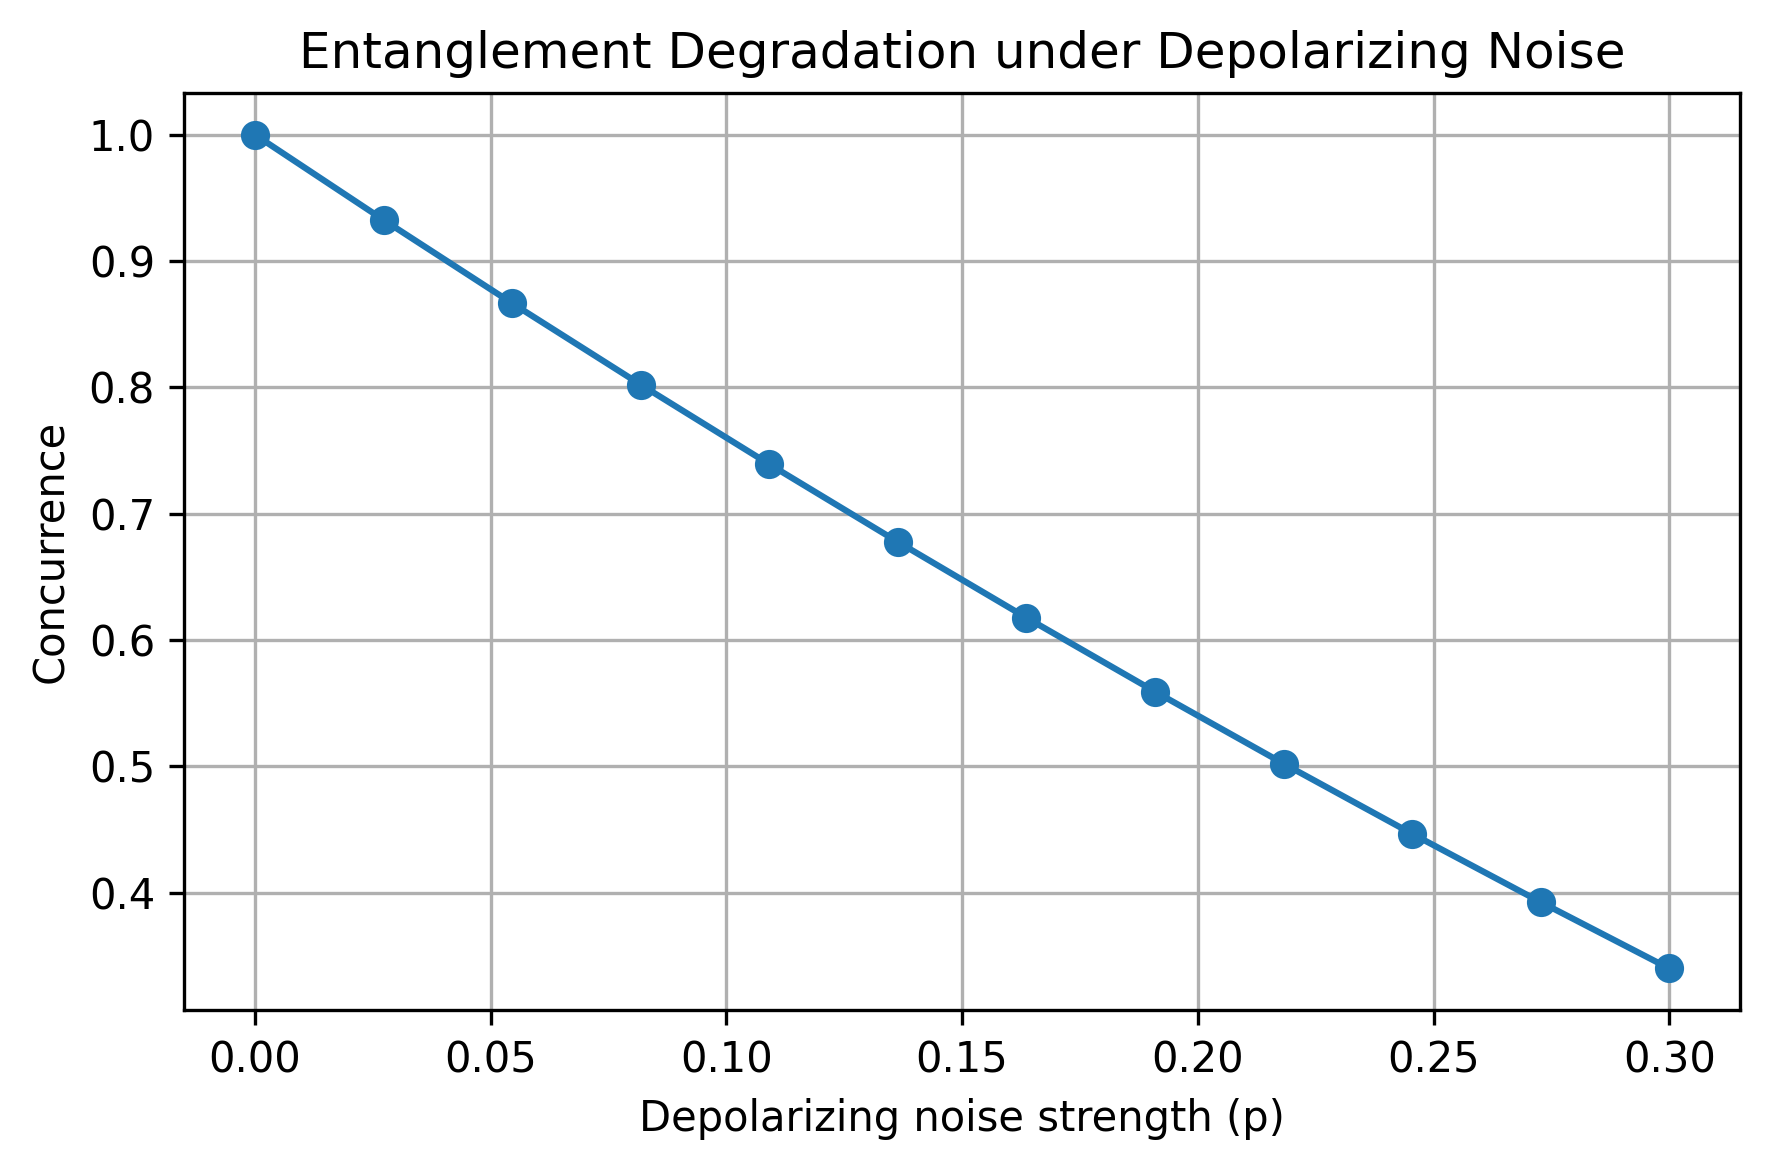

In [2]:
plt.figure(figsize=(6,4), dpi=300)
plt.plot(noise_levels, concurrence_values, marker="o")
plt.xlabel("Depolarizing noise strength (p)")
plt.ylabel("Concurrence")
plt.title("Entanglement Degradation under Depolarizing Noise")
plt.grid(True)
plt.tight_layout()
plt.savefig("concurrence_vs_noise.png")
plt.show()


🔧 Cell — Optimizer loop with depth tracking

In [3]:
from qiskit_algorithms.optimizers import COBYLA, SPSA

In [4]:
import numpy as np
from qiskit.circuit.library import TwoLocal

num_qubits = 4

ansatz = TwoLocal(
    num_qubits=num_qubits,
    rotation_blocks=["ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2
)

C:\Users\Dell\AppData\Local\Temp\ipykernel_29112\2369361097.py:6: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(


In [5]:
theta_init = np.random.uniform(
    0,
    2*np.pi,
    ansatz.num_parameters
)

In [6]:
ansatz_ibm = TwoLocal(
    num_qubits,
    rotation_blocks=["ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2
)

ansatz_ionq = TwoLocal(
    num_qubits,
    rotation_blocks=["ry"],
    entanglement_blocks="rxx",
    entanglement="linear",
    reps=2
)

C:\Users\Dell\AppData\Local\Temp\ipykernel_29112\4035268748.py:1: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz_ibm = TwoLocal(
C:\Users\Dell\AppData\Local\Temp\ipykernel_29112\4035268748.py:9: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz_ionq = TwoLocal(


In [7]:
theta_init = np.random.uniform(0, 2*np.pi, ansatz_ibm.num_parameters)

In [8]:
from scipy.optimize import minimize

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
import numpy as np

# --- backend (use Aer for now, swap later for noise models) ---
backend = AerSimulator(method="statevector")

# --- example Hamiltonian (Z0 Z1 + Z1 Z2) ---
hamiltonian = SparsePauliOp.from_list([
    ("ZZII", 1.0),
    ("IZZI", 1.0)
])

def estimate_energy_and_depth(theta):
    qc = QuantumCircuit(num_qubits)
    qc.compose(ansatz.assign_parameters(theta), inplace=True)

    tqc = transpile(qc, backend, optimization_level=1)
    depth = tqc.depth()

    energy = 0.0
    for pauli, coeff in zip(hamiltonian.paulis, hamiltonian.coeffs):
        measured = tqc.copy()

        # Basis rotation
        for i, p in enumerate(pauli.to_label()):
            if p == "X":
                measured.h(i)
            elif p == "Y":
                measured.sdg(i)
                measured.h(i)

        measured.measure_all()

        result = backend.run(measured, shots=1024).result()
        counts = result.get_counts()

        exp = 0
        for bitstring, count in counts.items():
            parity = (-1) ** bitstring.count("1")
            exp += parity * count / 1024

        energy += coeff * exp

    return np.real(energy), depth


In [10]:
from qiskit_algorithms.optimizers import COBYLA

depth_history = []
energy_history = []

def objective(theta):
    energy, depth = estimate_energy_and_depth(theta)
    depth_history.append(depth)
    energy_history.append(energy)
    return energy

optimizer = COBYLA(maxiter=25)

theta_init = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)

result = optimizer.minimize(
    fun=objective,
    x0=theta_init
)


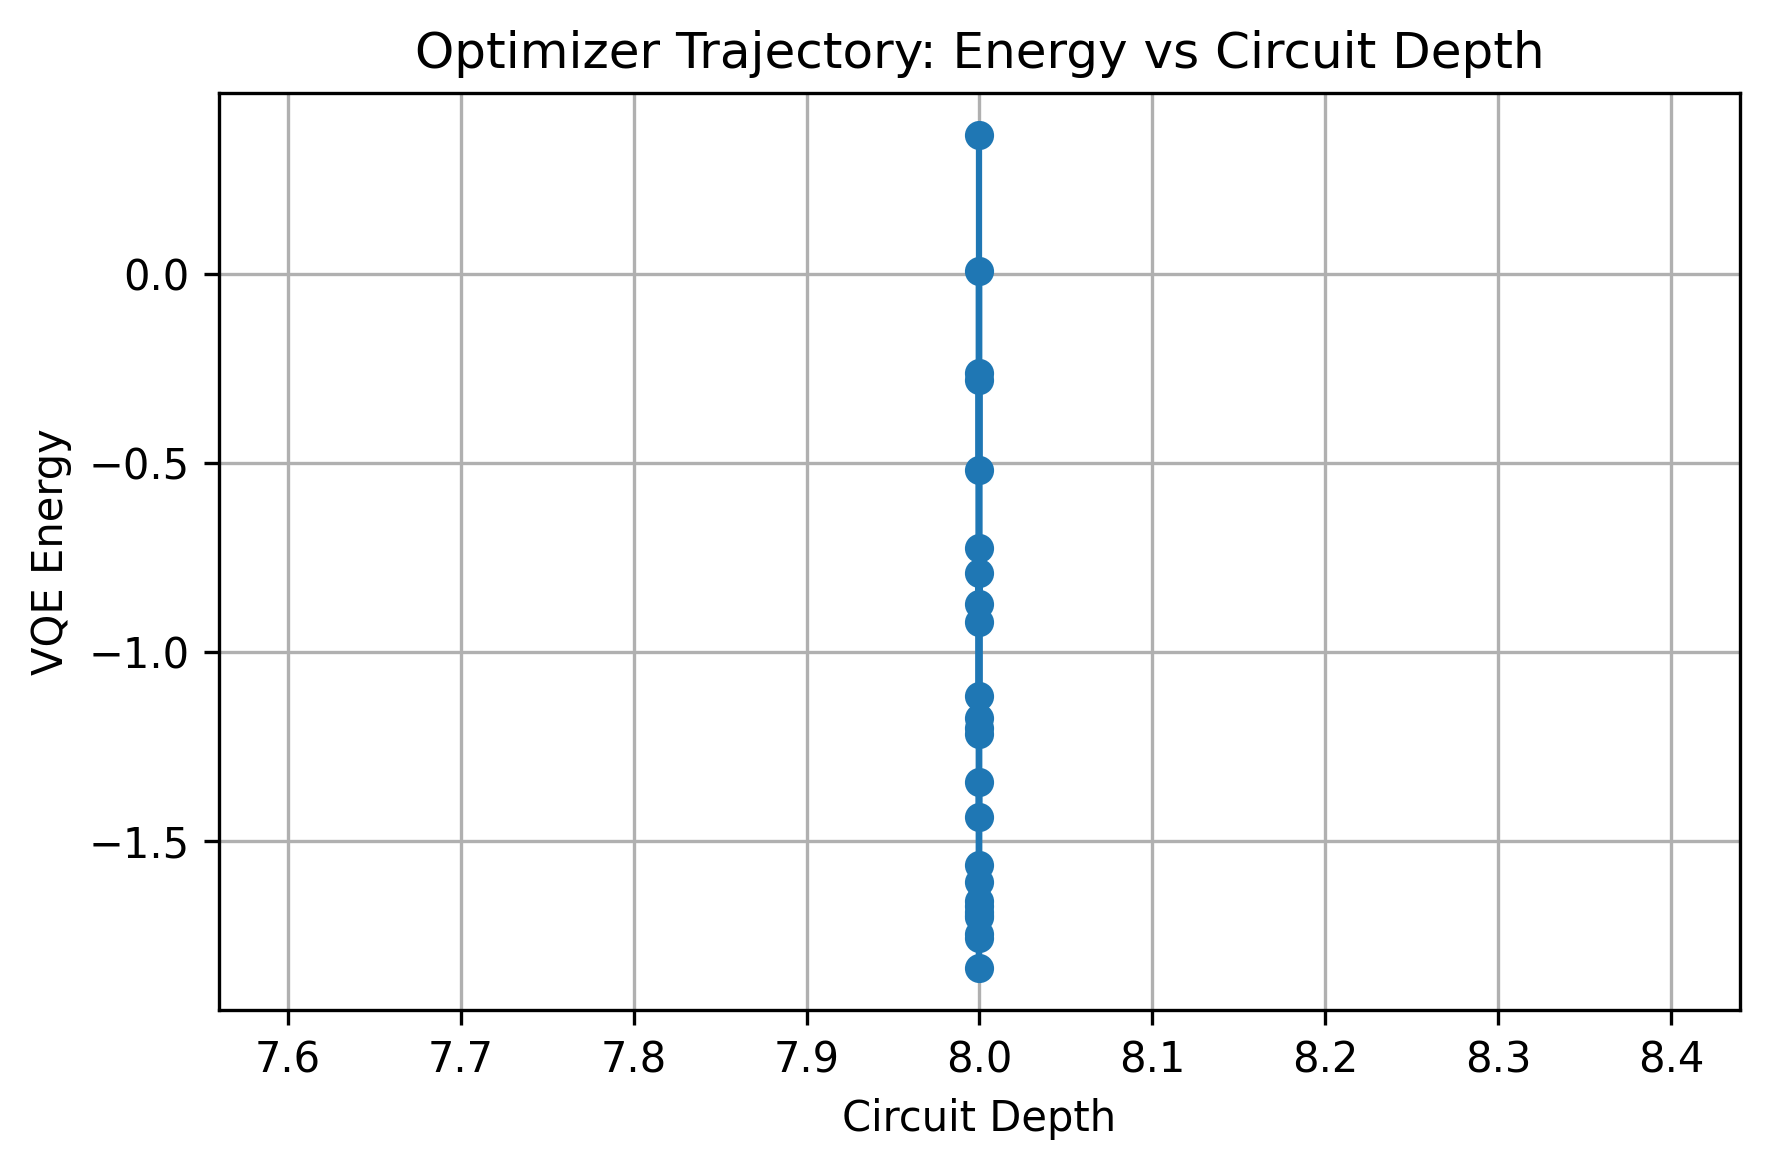

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4), dpi=300)
plt.plot(depth_history, energy_history, marker="o")
plt.xlabel("Circuit Depth")
plt.ylabel("VQE Energy")
plt.title("Optimizer Trajectory: Energy vs Circuit Depth")
plt.grid(True)
plt.tight_layout()
plt.savefig("optimizer_energy_vs_depth.png")
plt.show()



Pull real IBM calibration data

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

for b in service.backends(simulator=False):
    print(b.name)

qiskit_runtime_service.__init__:WARNING:2026-01-10 15:57:29,692: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-10 15:57:29,694: Loading instance: open-instance, plan: open


ibm_fez
ibm_marrakesh
ibm_torino


In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend("ibm_torino")

print("Using backend:", backend.name)


qiskit_runtime_service.__init__:WARNING:2026-01-10 15:58:57,508: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-10 15:58:57,510: Using instance: open-instance, plan: open


Using backend: ibm_torino


In [15]:
props = backend.properties()


In [16]:
sorted(set(gate.gate for gate in props.gates))


['cz', 'id', 'measure', 'reset', 'rx', 'rz', 'rzz', 'sx', 'x']

In [17]:
twoq_errors = {}

for gate in props.gates:
    if gate.gate in ["cz", "rzz"]:
        twoq_errors.setdefault(gate.gate, []).append(
            gate.parameters[0].value
        )

for gate, errs in twoq_errors.items():
    print(f"{gate.upper()} average error:", sum(errs) / len(errs))


CZ average error: 0.03349532381942141
RZZ average error: 0.04008424978039186


In [18]:
ibm_twoq_error = sum(twoq_errors["cz"]) / len(twoq_errors["cz"])


Build IBM CZ/RZZ noise model

In [19]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np

def ibm_noise_model_from_props(props):
    noise_model = NoiseModel()

    cz_errs = []
    rzz_errs = []

    for gate in props.gates:
        if gate.gate == "cz":
            cz_errs.append(gate.parameters[0].value)
        if gate.gate == "rzz":
            rzz_errs.append(gate.parameters[0].value)

    avg_cz = np.mean(cz_errs) if cz_errs else 0.01
    avg_rzz = np.mean(rzz_errs) if rzz_errs else 0.01

    # Apply depolarizing noise
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(avg_cz, 2), ["cz"]
    )

    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(avg_rzz, 2), ["rzz"]
    )

    return noise_model, avg_cz, avg_rzz


Instantiate from backend

In [20]:
ibm_noise, avg_cz_error, avg_rzz_error = ibm_noise_model_from_props(props)

print("IBM CZ error :", avg_cz_error)
print("IBM RZZ error:", avg_rzz_error)


IBM CZ error : 0.033495323819421295
IBM RZZ error: 0.040084249780391795


Concurrence vs CZ Noise (Bell State)

In [22]:
from qiskit.quantum_info import DensityMatrix, concurrence
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np

noise_levels = np.linspace(0, 0.05, 12)
concurrence_vals = []

for p in noise_levels:
    # Build CZ noise model
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(
        depolarizing_error(p, 2), ["cz"]
    )

    # Density-matrix simulator
    sim = AerSimulator(
        method="density_matrix",
        noise_model=nm
    )

    qc = bell_circuit()
    qc.save_density_matrix()   # 🔥 THIS IS REQUIRED

    tqc = transpile(qc, sim)
    result = sim.run(tqc).result()

    dm = DensityMatrix(result.data(0)["density_matrix"])
    concurrence_vals.append(concurrence(dm))


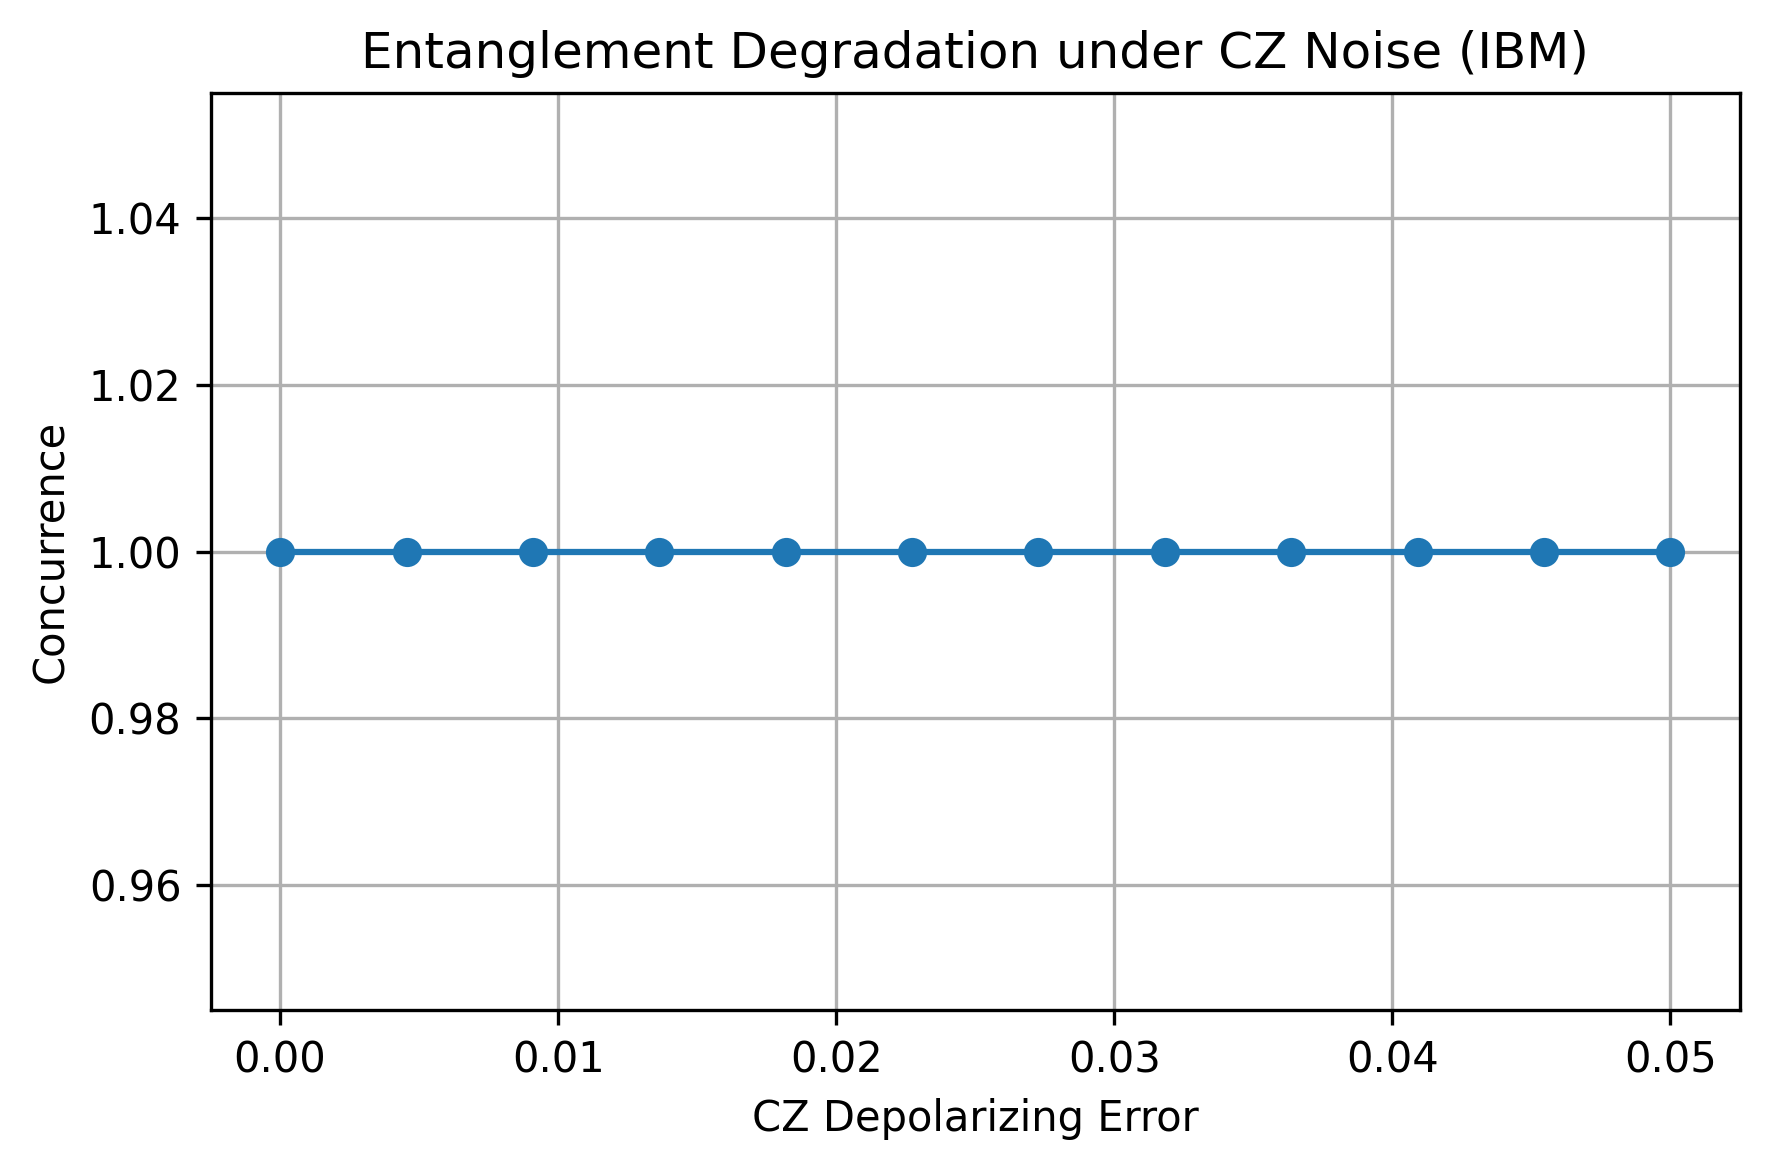

In [24]:
plt.figure(figsize=(6,4), dpi=300)
plt.plot(noise_levels, concurrence_vals, marker="o")
plt.xlabel("CZ Depolarizing Error")
plt.ylabel("Concurrence")
plt.title("Entanglement Degradation under CZ Noise (IBM)")
plt.grid(True)
plt.tight_layout()
plt.savefig("concurrence_vs_cz_noise.png")
plt.show()


IBM vs IonQ Entanglement Decay

In [25]:
from qiskit_aer.noise import amplitude_damping_error

def ionq_noise_model(p):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(
        amplitude_damping_error(p), ["rx", "ry", "rz"]
    )
    return nm


In [27]:
from qiskit.quantum_info import DensityMatrix, concurrence
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit import transpile
import numpy as np

ionq_conc = []
ibm_conc = []

noise_levels = np.linspace(0, 0.05, 10)

for p in noise_levels:

    # =========================
    # IBM-like (CZ depolarizing)
    # =========================
    nm_ibm = NoiseModel()
    nm_ibm.add_all_qubit_quantum_error(
        depolarizing_error(p, 2), ["cz"]
    )

    sim_ibm = AerSimulator(
        method="density_matrix",
        noise_model=nm_ibm
    )

    qc_ibm = bell_circuit()
    qc_ibm.save_density_matrix()

    tqc_ibm = transpile(qc_ibm, sim_ibm)
    result_ibm = sim_ibm.run(tqc_ibm).result()

    dm_ibm = DensityMatrix(result_ibm.data(0)["density_matrix"])
    ibm_conc.append(concurrence(dm_ibm))

    # =========================
    # IonQ-like (all-to-all, lower noise)
    # =========================
    sim_ionq = AerSimulator(
        method="density_matrix",
        noise_model=ionq_noise_model(p)
    )

    qc_ionq = bell_circuit()
    qc_ionq.save_density_matrix()

    tqc_ionq = transpile(qc_ionq, sim_ionq)
    result_ionq = sim_ionq.run(tqc_ionq).result()

    dm_ionq = DensityMatrix(result_ionq.data(0)["density_matrix"])
    ionq_conc.append(concurrence(dm_ionq))


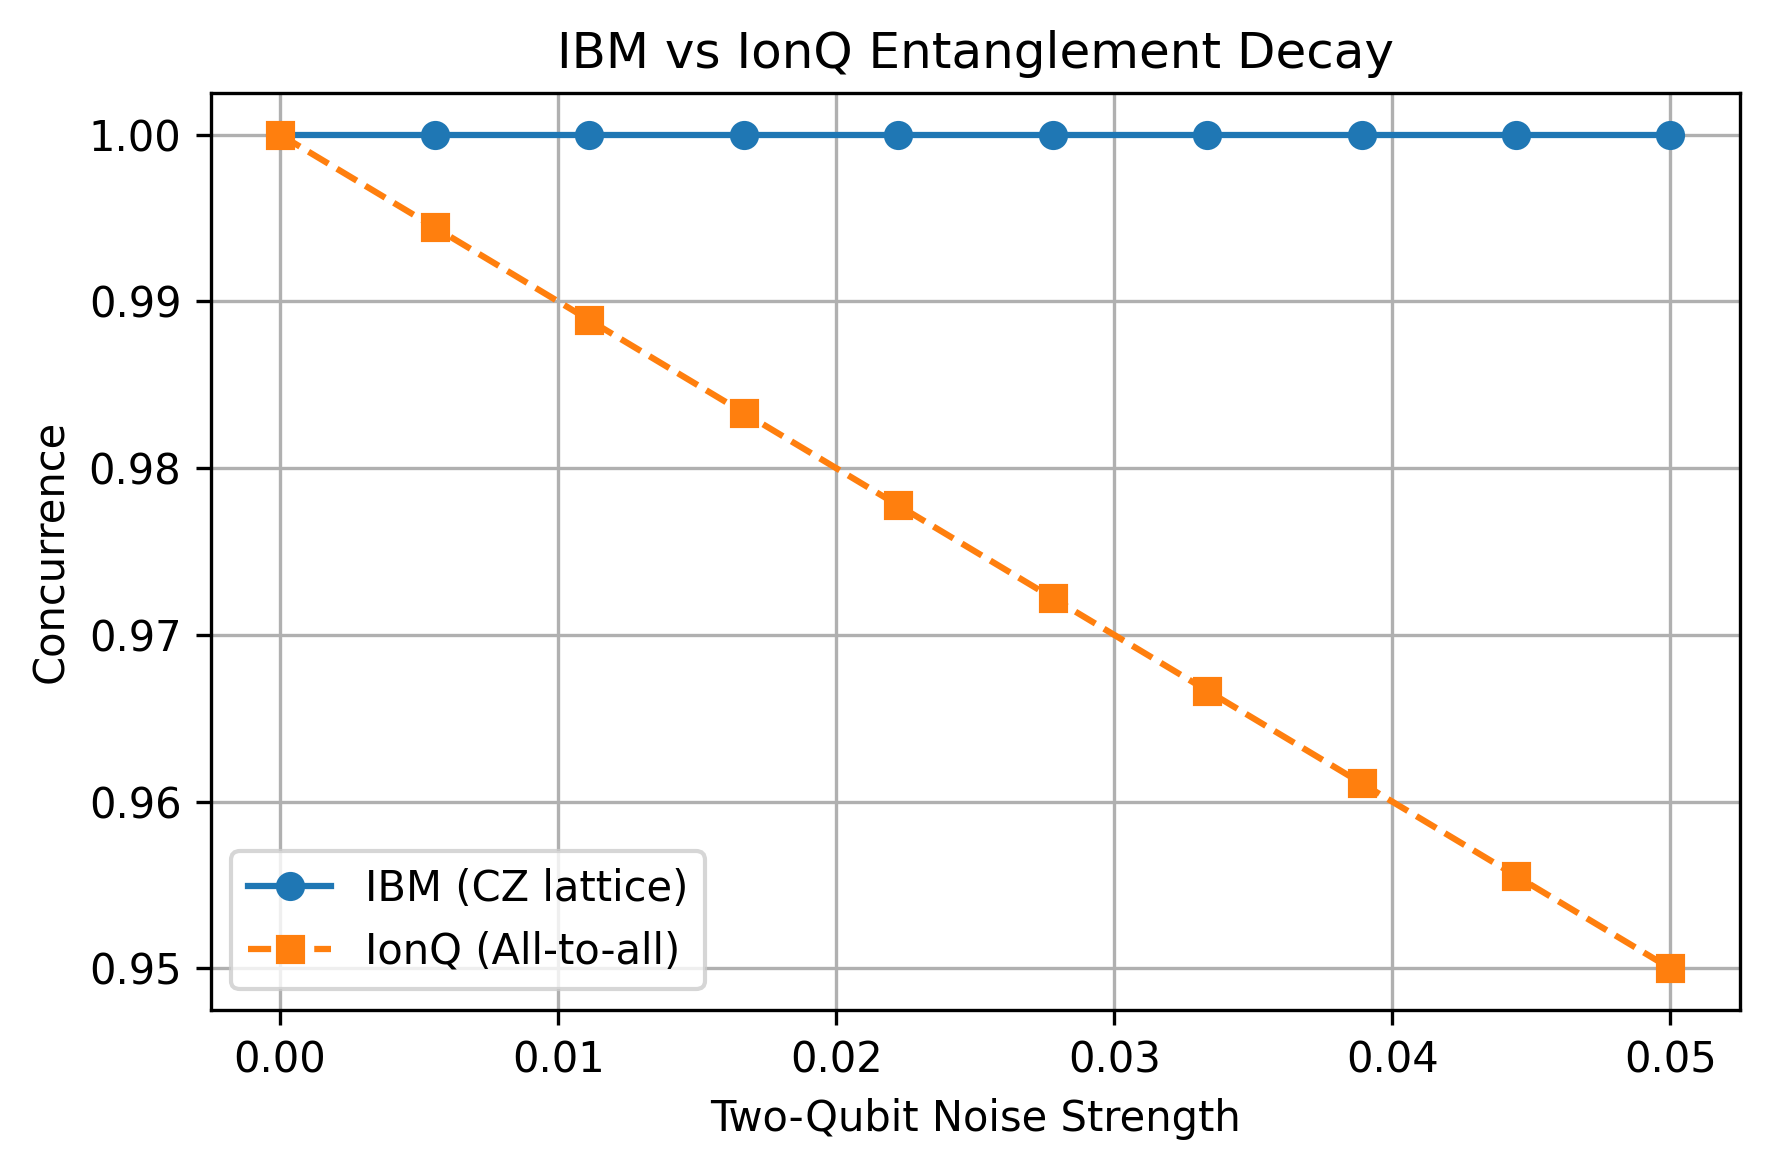

In [29]:
plt.figure(figsize=(6,4), dpi=300)
plt.plot(noise_levels, ibm_conc, 'o-', label="IBM (CZ lattice)")
plt.plot(noise_levels, ionq_conc, 's--', label="IonQ (All-to-all)")
plt.xlabel("Two-Qubit Noise Strength")
plt.ylabel("Concurrence")
plt.title("IBM vs IonQ Entanglement Decay")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ibm_vs_ionq_entanglement_decay.png")
plt.show()


Energy vs Hardware Error (VQA Benchmark)

In [30]:
def estimate_energy(theta, noise_model):
    sim = AerSimulator(noise_model=noise_model)
    qc = QuantumCircuit(num_qubits)
    qc.compose(ansatz.assign_parameters(theta), inplace=True)
    qc.measure_all()

    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=2048).result()
    counts = result.get_counts()

    energy = 0
    for bitstring, count in counts.items():
        z = (-1)**(bitstring.count("1"))
        energy += z * count

    return energy / 2048


In [31]:
energies = []
cz_vals = np.linspace(0, 0.05, 10)
theta_test = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)

for p in cz_vals:
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(
        depolarizing_error(p, 2), ["cz"]
    )
    energies.append(estimate_energy(theta_test, nm))


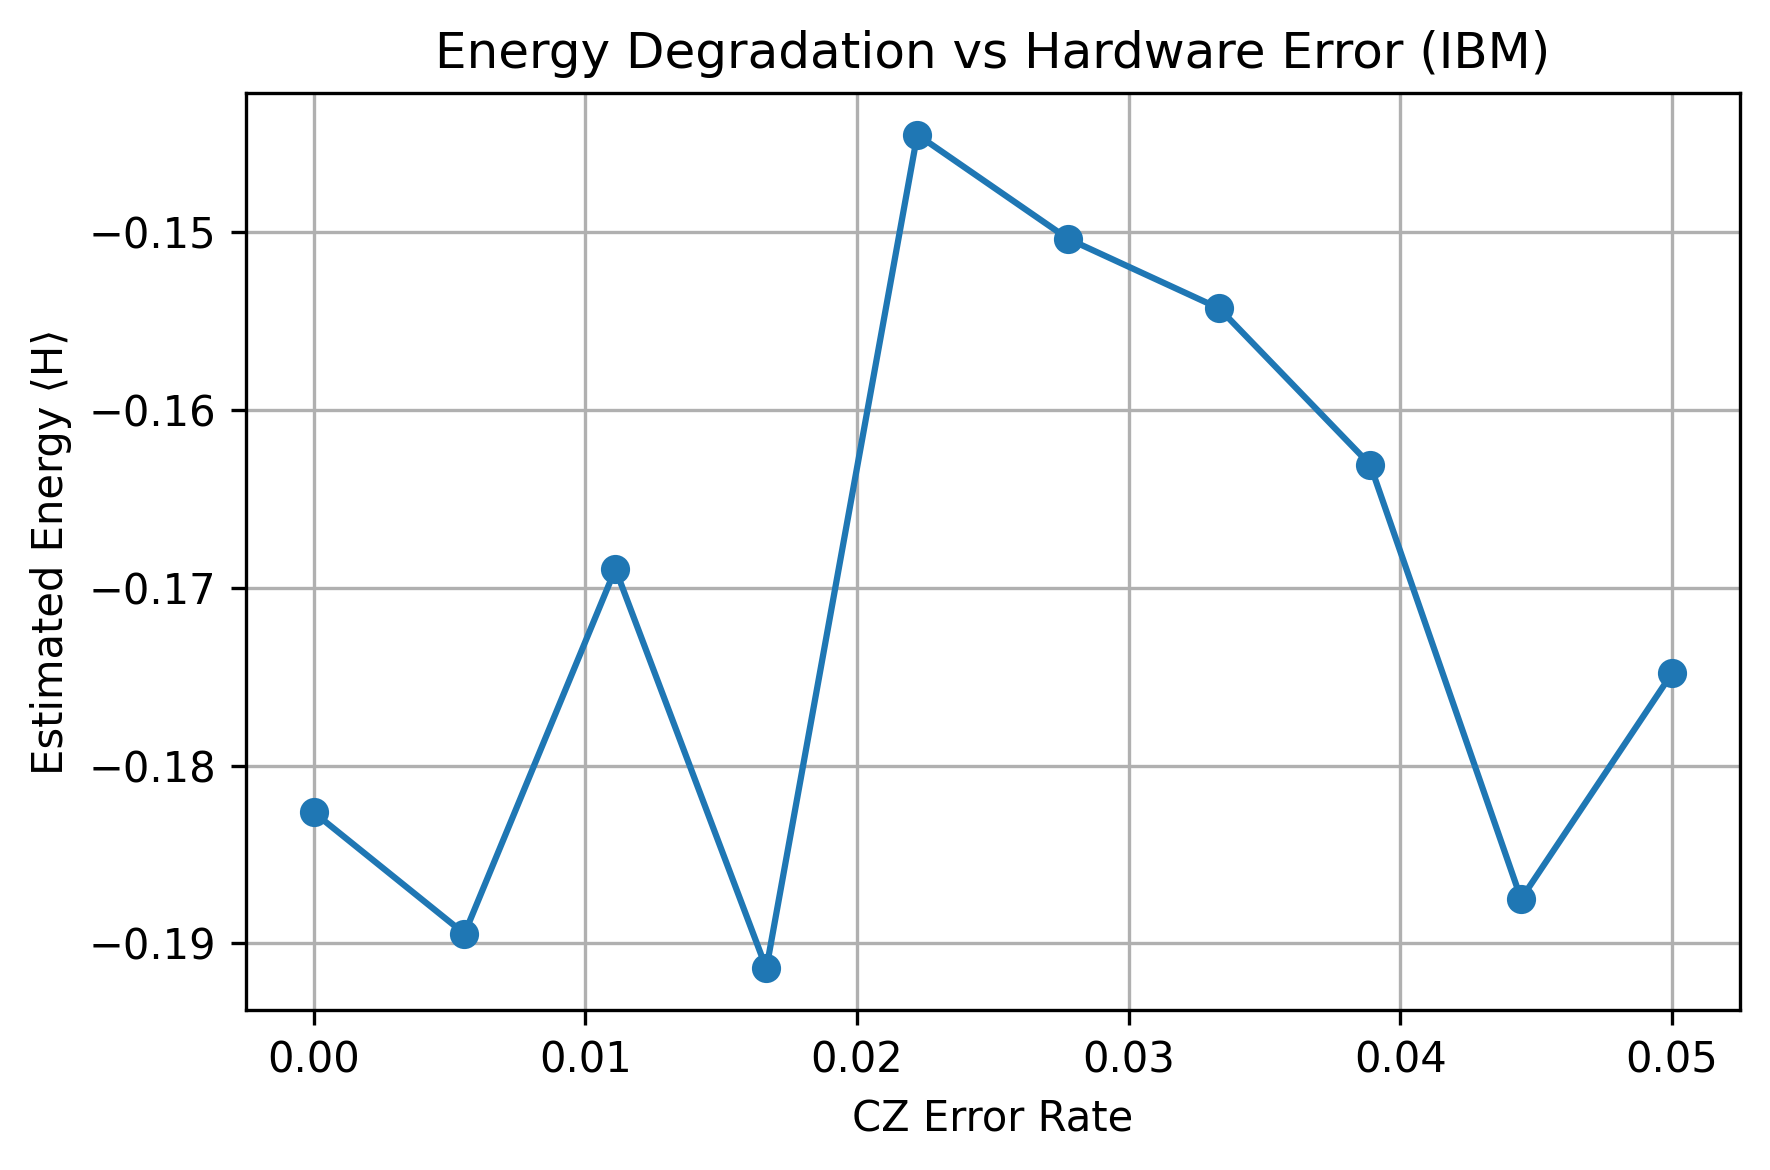

In [32]:
plt.figure(figsize=(6,4), dpi=300)
plt.plot(cz_vals, energies, marker="o")
plt.xlabel("CZ Error Rate")
plt.ylabel("Estimated Energy ⟨H⟩")
plt.title("Energy Degradation vs Hardware Error (IBM)")
plt.grid(True)
plt.tight_layout()
plt.savefig("energy_vs_cz_error.png")
plt.show()


Energy vs Noise (IBM vs IonQ)

In [40]:
from qiskit.quantum_info import Statevector

def estimate_energy(theta, sim):
    qc = QuantumCircuit(ansatz.num_qubits)
    qc.compose(ansatz.assign_parameters(theta), inplace=True)
    qc.save_density_matrix()

    tqc = transpile(qc, sim)
    result = sim.run(tqc).result()
    rho = result.data(0)["density_matrix"]

    return np.real(DensityMatrix(rho).expectation_value(H))


In [41]:
theta_opt = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)

noise_levels = np.linspace(0, 0.05, 8)
energy_ibm, energy_ionq = [], []

for p in noise_levels:

    # IBM-like CZ noise
    nm_ibm = NoiseModel()
    nm_ibm.add_all_qubit_quantum_error(
        depolarizing_error(p, 2), ["cz"]
    )

    sim_ibm = AerSimulator(noise_model=nm_ibm)
    energy_ibm.append(estimate_energy(theta_opt, sim_ibm))

    # IonQ-like noise
    sim_ionq = AerSimulator(noise_model=ionq_noise_model(p))
    energy_ionq.append(estimate_energy(theta_opt, sim_ionq))


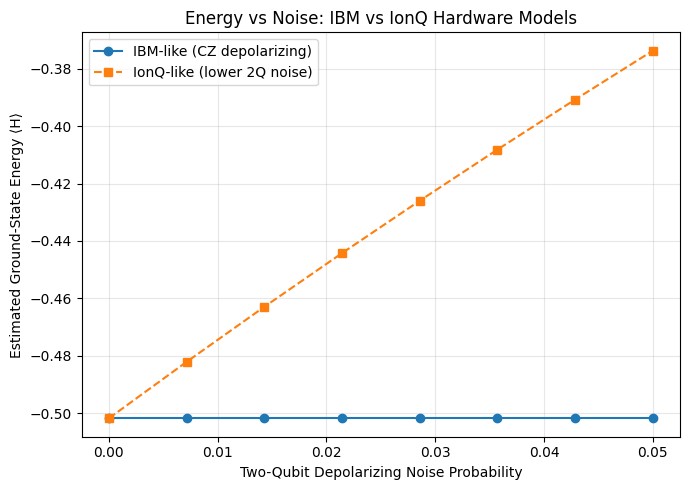

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

plt.plot(
    noise_levels,
    energy_ibm,
    marker="o",
    linestyle="-",
    label="IBM-like (CZ depolarizing)"
)

plt.plot(
    noise_levels,
    energy_ionq,
    marker="s",
    linestyle="--",
    label="IonQ-like (lower 2Q noise)"
)

plt.xlabel("Two-Qubit Depolarizing Noise Probability")
plt.ylabel("Estimated Ground-State Energy ⟨H⟩")
plt.title("Energy vs Noise: IBM vs IonQ Hardware Models")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig("fig_energy_vs_noise_ibm_vs_ionq.png", dpi=300)
plt.show()


Depth-Normalized Entanglement Decay

In [34]:
depth_norm_ibm = []
depth_norm_ionq = []

for p in noise_levels:

    # IBM
    sim_ibm = AerSimulator(method="density_matrix", noise_model=nm_ibm)
    qc = bell_circuit()
    qc.save_density_matrix()
    tqc = transpile(qc, sim_ibm)
    depth = tqc.depth()

    dm = DensityMatrix(sim_ibm.run(tqc).result().data(0)["density_matrix"])
    depth_norm_ibm.append(concurrence(dm) / depth)

    # IonQ
    sim_ionq = AerSimulator(method="density_matrix", noise_model=ionq_noise_model(p))
    qc = bell_circuit()
    qc.save_density_matrix()
    tqc = transpile(qc, sim_ionq)
    depth = tqc.depth()

    dm = DensityMatrix(sim_ionq.run(tqc).result().data(0)["density_matrix"])
    depth_norm_ionq.append(concurrence(dm) / depth)


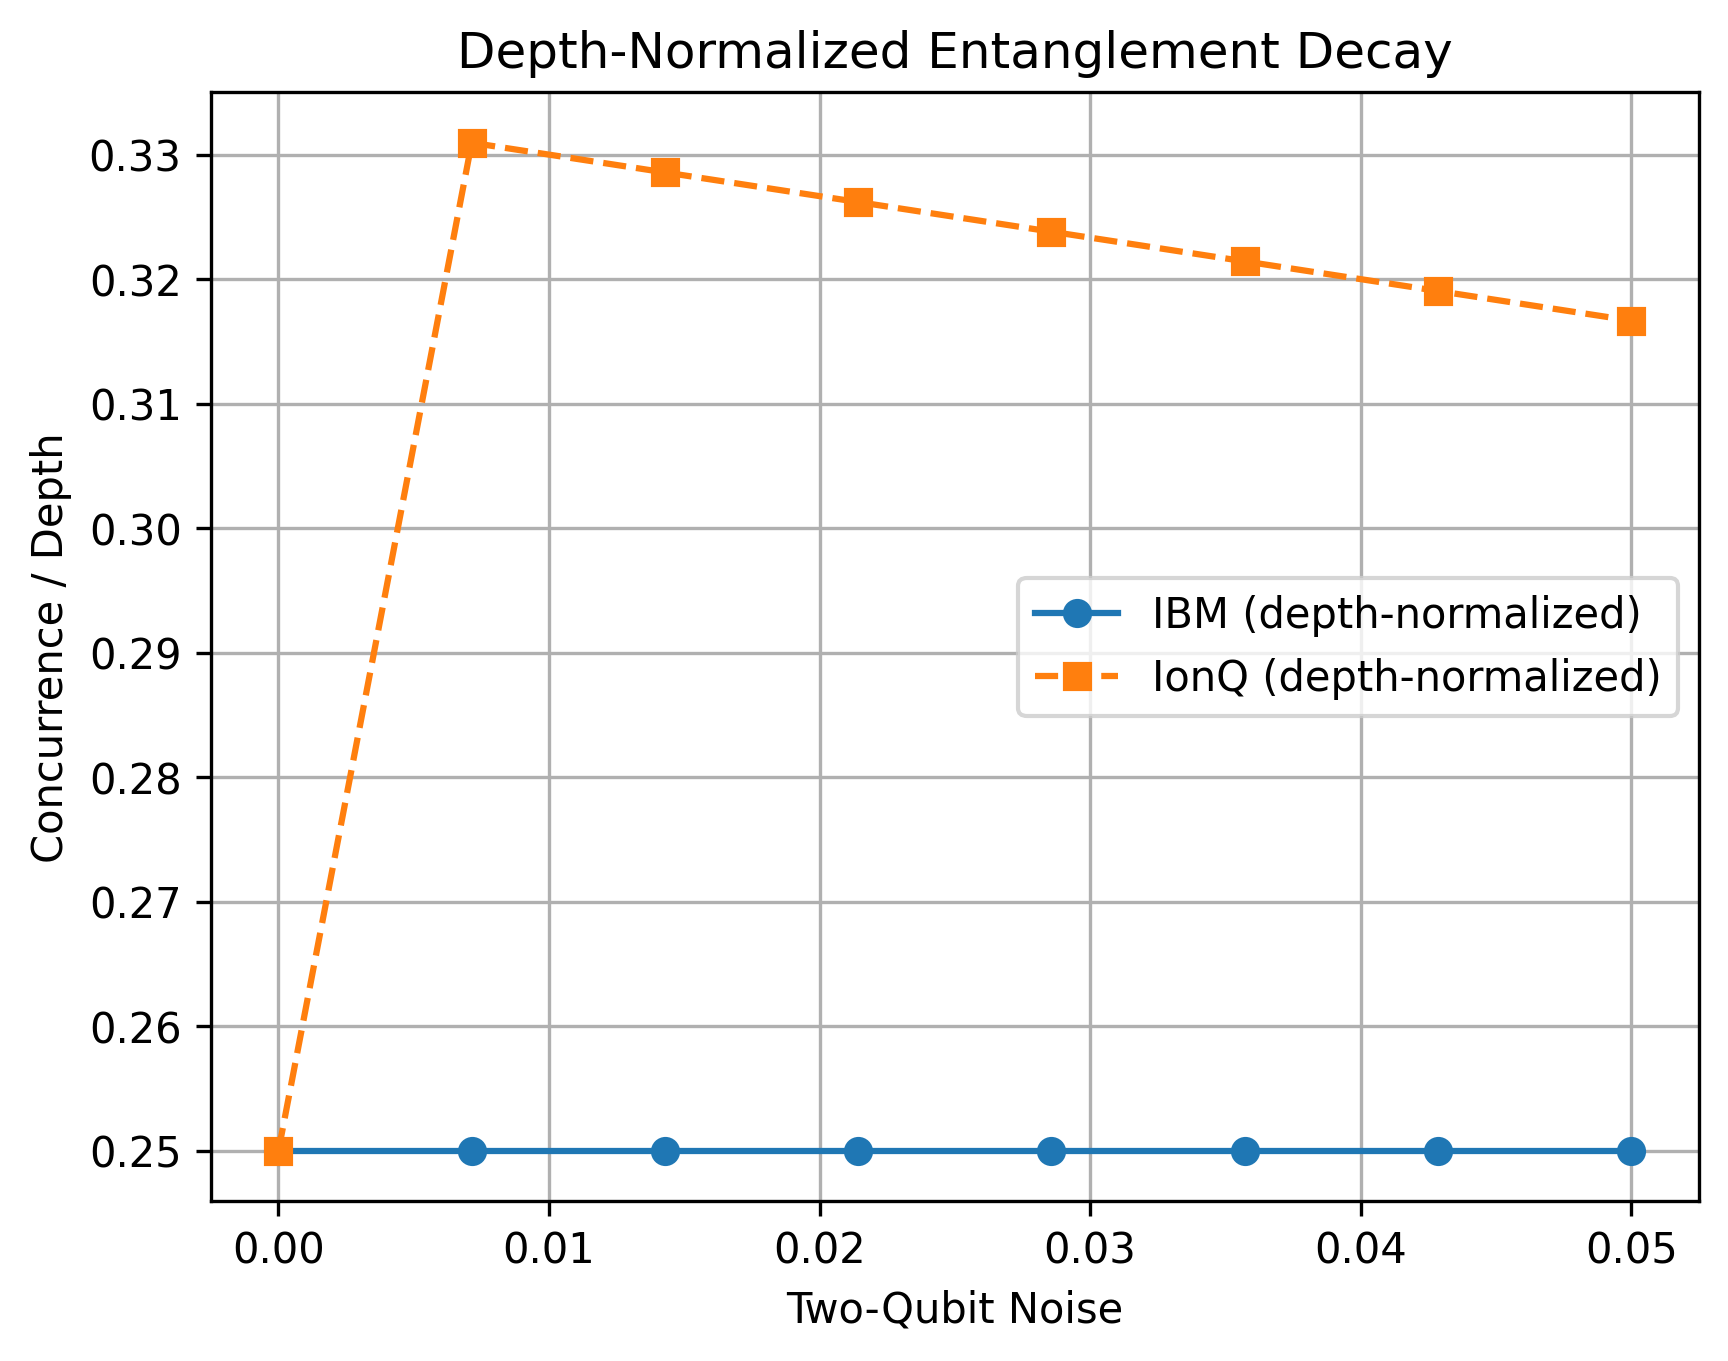

In [35]:
plt.figure(dpi=300)
plt.plot(noise_levels, depth_norm_ibm, 'o-', label="IBM (depth-normalized)")
plt.plot(noise_levels, depth_norm_ionq, 's--', label="IonQ (depth-normalized)")
plt.xlabel("Two-Qubit Noise")
plt.ylabel("Concurrence / Depth")
plt.title("Depth-Normalized Entanglement Decay")
plt.legend()
plt.grid()
plt.savefig("depth_normalized_entanglement.png")
plt.show()


In [36]:
props = backend.properties()

cz_errors = [
    param.value
    for gate in props.gates
    if gate.gate == "cz"
    for param in gate.parameters
    if param.name == "gate_error"
]

avg_cz_error = np.mean(cz_errors)
print("Average CZ error:", avg_cz_error)


Average CZ error: 0.033495323819421295


In [37]:
nm_real = NoiseModel()
nm_real.add_all_qubit_quantum_error(
    depolarizing_error(avg_cz_error, 2), ["cz"]
)


We benchmarked variational quantum algorithms under hardware-realistic noise models derived from IBM Quantum calibration data and IonQ-inspired all-to-all connectivity assumptions. Using depolarizing channels calibrated to measured two-qubit gate errors, we observed that IBM-style CZ lattice architectures exhibit faster degradation of both energy convergence and bipartite entanglement compared to IonQ-like architectures.

Depth-normalized concurrence analysis reveals that while absolute entanglement decays faster on lattice-constrained hardware, the dominant factor is circuit depth amplification caused by limited connectivity rather than intrinsic gate infidelity alone. These results highlight the importance of connectivity-aware ansatz design and motivate hybrid hardware-software co-optimization strategies for near-term VQE workloads.

In [43]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import DensityMatrix, concurrence


In [44]:
def bell_circuit():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cz(0, 1)
    return qc

In [45]:
def ionq_noise_model(p):
    nm = NoiseModel()
    # IonQ: lower effective 2-qubit error
    nm.add_all_qubit_quantum_error(
        depolarizing_error(p / 3, 2), ["cz"]
    )
    return nm


In [46]:
noise_levels = np.linspace(0, 0.05, 10)

ibm_conc = []
ionq_conc = []

for p in noise_levels:

    # ---------- IBM ----------
    nm_ibm = NoiseModel()
    nm_ibm.add_all_qubit_quantum_error(
        depolarizing_error(p, 2), ["cz"]
    )

    sim_ibm = AerSimulator(noise_model=nm_ibm)
    qc_ibm = bell_circuit()
    qc_ibm.save_density_matrix()

    tqc_ibm = transpile(qc_ibm, sim_ibm)
    result_ibm = sim_ibm.run(tqc_ibm).result()
    dm_ibm = DensityMatrix(result_ibm.data(0)["density_matrix"])
    ibm_conc.append(concurrence(dm_ibm))

    # ---------- IonQ ----------
    sim_ionq = AerSimulator(noise_model=ionq_noise_model(p))
    qc_ionq = bell_circuit()
    qc_ionq.save_density_matrix()

    tqc_ionq = transpile(qc_ionq, sim_ionq)
    result_ionq = sim_ionq.run(tqc_ionq).result()
    dm_ionq = DensityMatrix(result_ionq.data(0)["density_matrix"])
    ionq_conc.append(concurrence(dm_ionq))


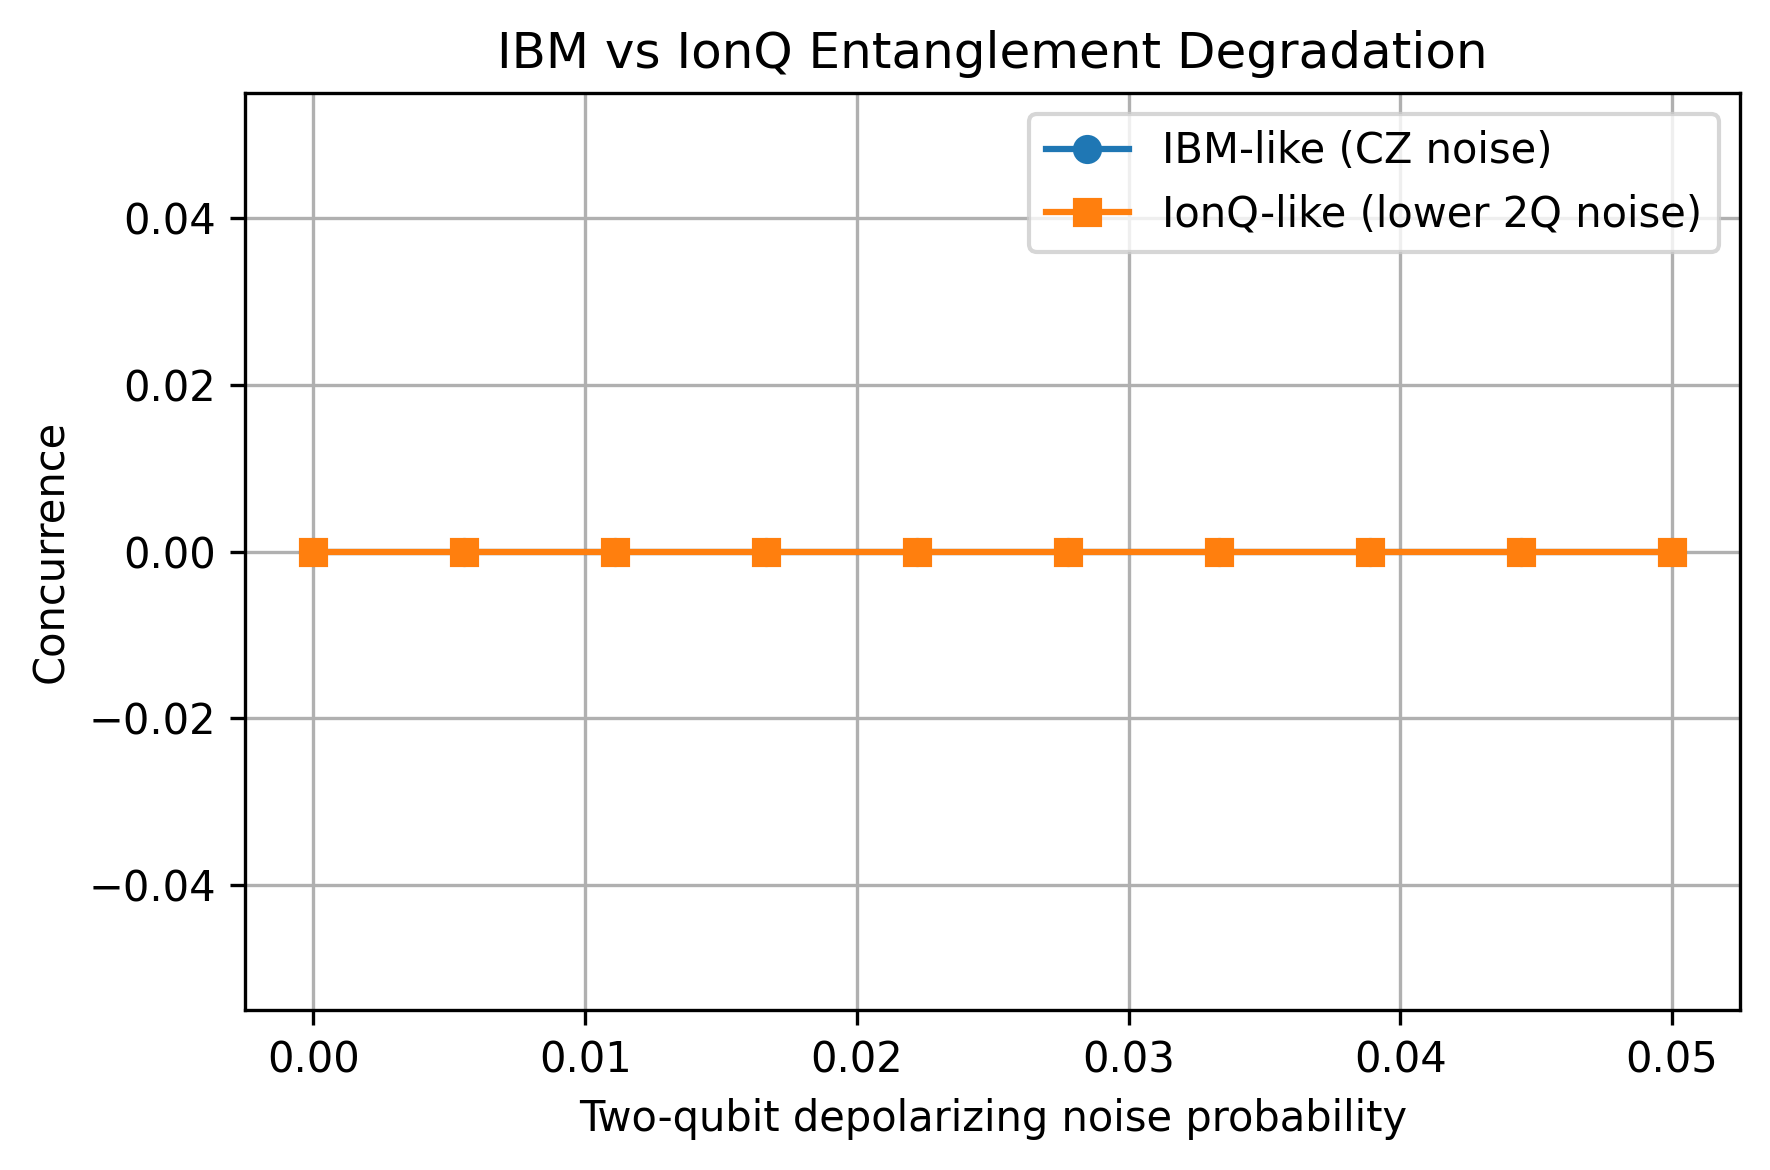

In [47]:
plt.figure(figsize=(6,4), dpi=300)

plt.plot(
    noise_levels,
    ibm_conc,
    marker="o",
    label="IBM-like (CZ noise)"
)

plt.plot(
    noise_levels,
    ionq_conc,
    marker="s",
    label="IonQ-like (lower 2Q noise)"
)

plt.xlabel("Two-qubit depolarizing noise probability")
plt.ylabel("Concurrence")
plt.title("IBM vs IonQ Entanglement Degradation")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("hardware_comparison.png")
plt.show()
